In [11]:
import torch
from data.data_loader import get_dataset
from utils import get_device
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [46]:
def reconstruct_tweaks(dataset, model_load_path, min_tweak=-0.5, max_tweak=0.5, n_steps=9):
    """ Compute the reconstruction of tweaked capsule ouputs.
    
    From the test set we take the first batch. We compute the final capsules. Using the function tweak_caps,
    we make tweaked versions of these final capsules. Using the decoder network, we compute for each tweaked version 
    the reconstruction. 
    
    Args: 
        dataset (str): Dataset to use. Chose from: mnist, fashionmnist or cifar10.
        model_load_path (str): Path of the model to be loaded.
        min_tweak (float, optional): Min tweak value. Hinton uses -0.25.
        max_tweak (float, optional): Max tweak value. Hinton uses 0.25.
        n_steps (int, optional): Number of steps between min and max.
    
    Returns: 
        numpy.ndarray: Numpy array with the reconstructions of all tweaks. Shape: [batch_size, n_steps, dim_caps,
        data_channels, data_height, data_width]
    
    """

    _, data_test, data_shape, label_shape = get_dataset(dataset)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=128, drop_last=True)
    
    data_channels = data_shape[0]
    data_width = data_shape[1]
    data_height = data_shape[2]
    
    model = torch.load(model_load_path, map_location=lambda storage, loc: storage)
    model.eval()

    # set sparse method before included in BasicCapsNet
    model._modules["rout_layers"][0].sparse.set_off()
    
    # new method, does not work for all models
    #model.sparse.set_off()

    batch = iter(test_loader).next()

    with torch.no_grad():
        data = batch[0].to(get_device())
        labels = batch[1].to(get_device())

        logits, _, final_caps, entropy = model(data)

    labels = labels.data.cpu().numpy()
    digit_caps = final_caps.data.cpu().numpy()

    # compute tweak caps
    caps_tweak = tweak_caps(digit_caps, min_tweak, max_tweak, n_steps)

    # compute labels and flatten to be able to feed as batch
    batch_size, _, _, n_caps, dim_caps  = caps_tweak.shape

    # new_batch dim: tweak_dim, tweak_value, old_batch_index
    caps_tweak_flat = caps_tweak.reshape([-1, n_caps, dim_caps])
    labels_tweaks_flat = np.repeat(labels, n_steps * dim_caps)

    caps_tweak_flat = torch.from_numpy(caps_tweak_flat).to(torch.float32)
    labels_tweaks_flat = torch.from_numpy(labels_tweaks_flat).to(torch.int64)

    # create feed dict, feed and reshape again
    decoder_input = model.create_decoder_input(caps_tweak_flat, labels_tweaks_flat)
    recon_tweak_flat = model.decoder(decoder_input).squeeze().data.cpu().numpy()
    recon_tweak = recon_tweak_flat.reshape(batch_size, n_steps, dim_caps, data_channels, data_height, data_width)

    return recon_tweak


def tweak_caps(caps, minimum, maximum, n_steps): 
    """ Tweak multiple capsule by multiple tweak values. 
    
    In the einstein notation, we use: 
        b: batch_size
        i: step value
        m: dimension which is tweaked 
        j: number of caps
        n: dimension caps
    
    Args: 
        caps (Tensor): Capsules to be tweaked of shape [batch_size, dim_caps, n_caps]
        minimum (float): Starting value tweak value
        minimum (float): ending value tweak value
        n_steps (int): number of tweaks
    
    Returns: 
        (Tensor): tweaked capsules tensor of shape [batch_size, n_steps, dim_caps, n_caps, dim_caps] where 
            the axis correspond to: [batch_index, tweak_value, tweaked_dim, vector_index]. 
    """
    
    batch_size, n_caps, dim_caps = caps.shape
    steps = np.linspace(minimum, maximum, n_steps) 

    # select dim to tweak: zero tensor with 1 on location of dim to tweak for all steps
    dim_selector = np.einsum("j,nm->mjn", np.ones(n_caps), np.diag(np.ones(dim_caps)))

    # zero tensor with tweak on location of dim to tweak for all steps
    batch_dim_selector = np.tile(dim_selector, (batch_size, 1, 1, 1))
    tweak_values = np.einsum("i,bmjn->bimjn", steps, batch_dim_selector)

    expanded_caps = np.einsum("im,bjn->bimjn", np.ones([n_steps, dim_caps]), caps)

    tweaked_caps = tweak_values + expanded_caps
    
    return tweaked_caps
    
    
def plot_tweaks(batch_index, recon_tweak, title=None):
    """ Plot all reconstructed tweaked images. 
    
    Args: 
        batch_index (int): Element of the batch to plot.
        recon_tweak (numpy.Ndarray): Numpy array with the reconstructions of all tweaks. Shape: [batch_size, n_steps, dim_caps,
        data_channels, data_height, data_width]
        title (str, Optional): Title of the plot. No title added if not given. 
    """

    fig = plt.figure(figsize=(15,8))
    
    if title:
        plt.suptitle(title, fontsize="x-large")
        
    # index of sample from batch to show
    batch_index = 21
    
    _, n_steps, dim_caps, _, _, _ = recon_tweak.shape 
    
    # loop over dimensions
    for row in range(dim_caps):
        # loop over tweak steps
        for col in range(n_steps):
            
            # create subplot
            plt.subplot(dim_caps, n_steps, row * n_steps + col + 1)
            
            # get tweaked reconstruction
            image = recon_tweak[batch_index, col, row, :, :, :]
            
            # move channels to last dimensions, as numpy expects this
            image = np.moveaxis(image, 0, -1).squeeze()
            
            # remove 1 dimensions (grayscale)
            image = image.squeeze()

            plt.imshow(image, cmap="binary")
            plt.axis("off")

    plt.show() 

In [37]:
dataset = "mnist"

model_load_path = "./experiments/diff_sparse_new/trained_models/mnist_:nodes_topk_0.3-0.3:2402:_best_sparse__64.pth"
recon_tweaks_topk_mnist = reconstruct_tweaks(dataset, model_load_path)

model_load_path = "./experiments/diff_sparse_new/trained_models/mnist_:none:2402:__67.pth"
recon_tweaks_none_mnist = reconstruct_tweaks(dataset, model_load_path)

In [38]:
recon_tweaks_topk_mnist.shape
# image = recon_tweak[0, 0, 0, :, :, :]

# # move channels to last dimensions, as numpy expects this
# image = np.moveaxis(image, 0, -1).squeeze()

# # remove 1 dimensions (grayscale)
# image = image.squeeze()

# plt.imshow(image, cmap="binary")

(128, 9, 16, 1, 28, 28)

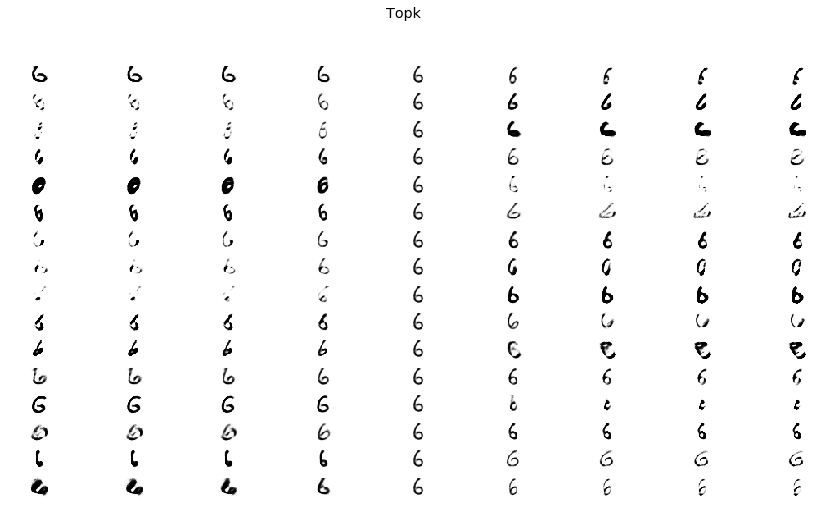

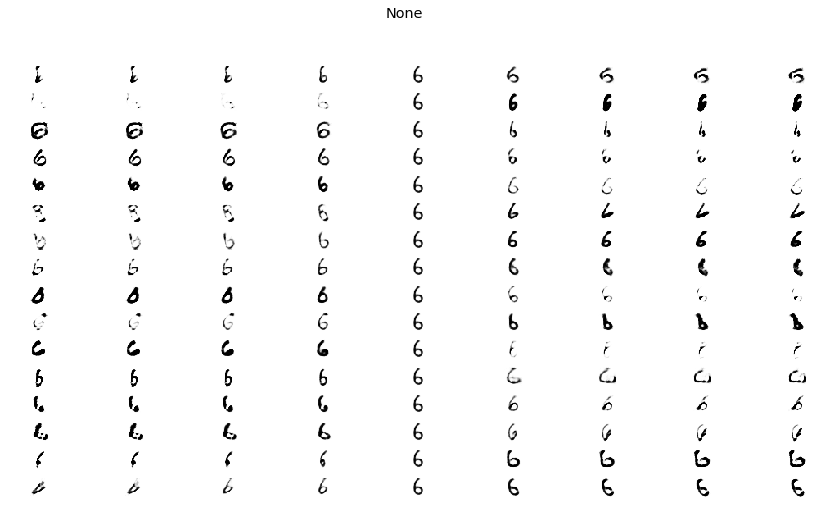

In [49]:
batch_index = 96

plot_tweaks(batch_index, recon_tweaks_topk_mnist, "Topk")
plot_tweaks(batch_index, recon_tweaks_none_mnist, "None")

In [40]:
dataset = "fashionmnist"

model_load_path = "./experiments/diff_sparse_new/trained_models/fashionmnist_:nodes_topk_0.3-0.3:1405:_best_sparse__40.pth"
recon_tweaks_topk_fashion = reconstruct_tweaks(dataset, model_load_path)

model_load_path = "./experiments/diff_sparse_new/trained_models/fashionmnist_:none:405:__49.pth"
recon_tweaks_none_fashion = reconstruct_tweaks(dataset, model_load_path)   



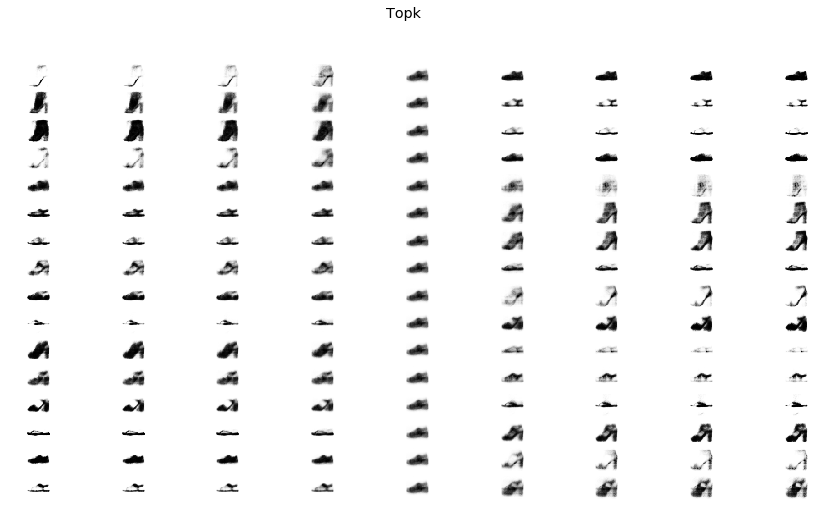

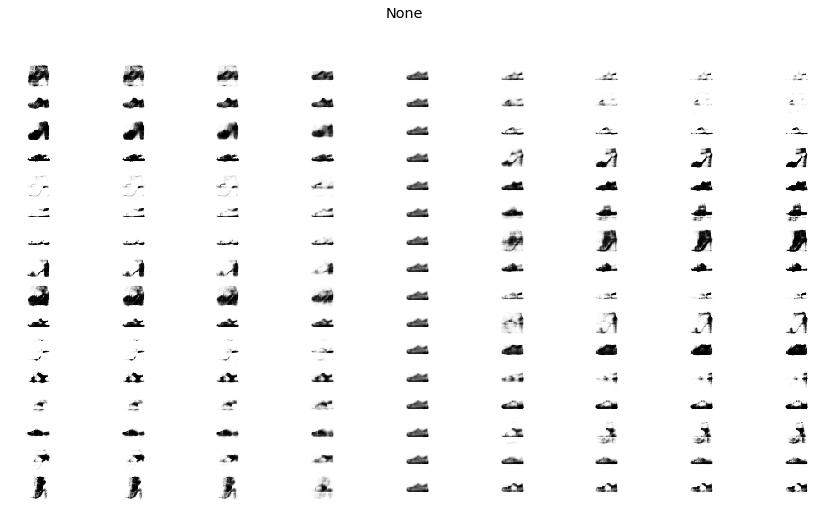

In [50]:
batch_index = 40

# plot_tweaks(batch_index, recon_tweaks_topk_fashion, "Topk")
plot_tweaks(batch_index, recon_tweaks_random_fashion, "Topk")
plot_tweaks(batch_index, recon_tweaks_none_fashion, "None")